# Regression & Bayesian Analysis with Food Deserts

## Abstract: 

### Motivation:
The insurance industry has played a major role in shaping the United State's healthcare system. Reimbursements, until recent years, were based on the acuity care, which promoted a sytem that focused primarily an acute illnesses that neccesitated hospitalization. This led to a "sickcare" system, that addressed complications of chronic disease, rather than promoting wellness and prevention. 

In an effort to address high healthcare associated costs, the healthcare enterprise is shifting their focus to prevention. Obesity, a major contributing factor of preventable chronic disease, has become one of the primary targets of recent healthcare reforms. That said, many efforts have been made to address areas of low food access, and the detrimental health effects caused by "Food Deserts". 

### Project Goals & Analysis Questions:
1. Explore factors that relate to "Food Deserts" in California:

2. Assess the relationship between "Food Deserts" and community health status
 
3. Determine whether "Food Desert" counties are also "Healthcare Deserts":
 - Do "Food Desert" counties have less access to healthcare services?
 - Do "Food Desert" counties have higher hospital readmission/mortality rates?
 - Do "Food Desert" counties have a higher rates of Opiod Rx's?



In [1]:
from scipy.stats.stats import pearsonr
import numpy as np
np.set_printoptions(precision=4, suppress=True)

import pandas as pd 
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import linear_model
from IPython.core.pylabtools import figsize
import scipy.stats as stats

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('/Users/desert/desert_workspace/desert_data/fd_data.csv')
df = df.drop('Unnamed: 0', axis=1)
df = df.fillna(0)
df.head()

,State,County,POP2010,food_deserts,pop_in_des,perc_lila,n_tracts,urban_des,rural_des,n_urban,...,vaccine_dx,food_dx,opiods_rx_1000,opiods_greater_than_stateavg,MILK_PRICE10,SODA_PRICE10,MILK_SODA_PRICE10,PCH_FFR_07_12,FFR07,FFR12
0,CA,Alameda,1510271,15,56082.0,0.018032,360,15.0,0.0,354,...,41.648155,29.597337,557.20,0,1.122215,1.164422,0.891575,8.902878,1112.0,1211
1,CA,Alpine,1175,0,0.0,0.266288,1,0.0,0.0,0,...,0.000000,0.000000,578.68,0,1.032918,1.089488,0.877073,-50.000000,2.0,1
2,CA,Amador,38091,0,0.0,0.149514,9,0.0,0.0,0,...,15.751752,13.126460,1244.76,1,1.032918,1.089488,0.877073,-5.555556,18.0,17
3,CA,Butte,220000,14,58979.0,0.145583,51,13.0,1.0,38,...,15.909091,27.727273,1389.20,1,0.996443,1.130546,0.815374,2.684564,149.0,153
4,CA,Calaveras,45578,0,0.0,0.203345,10,0.0,0.0,2,...,19.746369,10.970205,1068.98,1,1.032918,1.089488,0.877073,-7.407407,27.0,25


In [4]:
bayes_df = df[['food_deserts','cnty_dm_pct_adj','des_percent','POP2010' ]]
bayes_df['group'] = bayes_df['des_percent'] > np.mean(bayes_df['des_percent'])
bayes_df['group'].replace({False: 'low', True: 'high'},inplace=True)


bayes_df['n_diabetics']= bayes_df['cnty_dm_pct_adj'] * bayes_df['POP2010']
bayes_df['n_diabetics']=bayes_df['n_diabetics'].astype(int)

a = bayes_df[bayes_df['group']=='high']
b = bayes_df[bayes_df['group']=='low']
bayes_df.head()

/Users/desert/anaconda/envs/linreg/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/desert/anaconda/envs/linreg/lib/python2.7/site-packages/pandas/core/generic.py:3443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/desert/anaconda/envs/linreg/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

,food_deserts,cnty_dm_pct_adj,des_percent,POP2010,group,n_diabetics
0,15,0.078,0.041667,1510271,low,117801
1,0,0.077,0.000000,1175,low,90
2,0,0.075,0.000000,38091,low,2856
3,14,0.073,0.274510,220000,high,16059
4,0,0.067,0.000000,45578,low,3053


In [5]:
bayes = bayes_df.groupby('group').agg(np.mean)
bayes['cnty_dm_pct_adj']

group
high    0.075042
low     0.072647
Name: cnty_dm_pct_adj, dtype: float64

# Hypothesis:
## Do counties with a higher prevelance of Food Deserts have a higher prevelance of diabetes?

### Method - AB testing using a Bayesian approach
- A: Counties with a high prevelance of Food Deserts  
    - Includes counties that have a higher prevelance of food deserts than the statewide average.

- B: Counties with average to low prevelance of Food Deserts  
    - Includes counties that have a food desert prevelance that is less than statewide average. 

This analysis focuses on finding the true frequency of diabetic residents based on observed frequencies of seen in counties with a high prevelance of food deserts, and a low-to-average prevelance of food deserts. The true frequency can be interpreted as the probability of an event occurring. For example, the true frequency of getting heads when flipping a fair coin is 1/2. 

Conversely, the observed frequency is what is actually observed. An example being if we flipped a coin 100 times we may observe 40 heads, and 60 tails. Therefore the observed frequency often differs from the true frequency. However, by applying a bayesian approach we can obtain a better sense of the true frequencies, allowing us to compare the likelihood of a CA county resident being diabetic between the different county groups specified above.

To infer a probable value for the true frequency we can use the observed occurences in our dataset. Here we will compare the age adjusted diabetes prevelance between counties with a high prevelance of food deserts, and those with a low-to-average prevelance of food deserts. But first lets see how age adjusted diabetes rates vary among all CA counties, and each of these groups:

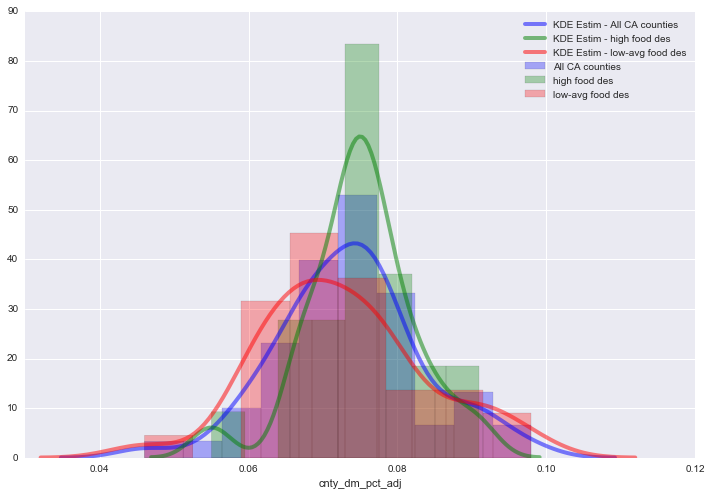

In [6]:
import pymc as pm
figsize(12, 8)


g=sns.distplot(bayes_df['cnty_dm_pct_adj'],
            kde_kws={"color":"b","lw":4,"label":"KDE Estim - All CA counties","alpha":0.5},
            hist_kws={"color":"b","alpha":0.3,"label":"All CA counties"})

sns.distplot(a['cnty_dm_pct_adj'],
            kde_kws={"color":"g","lw":4,"label":"KDE Estim - high food des","alpha":0.5},
            hist_kws={"color":"g","alpha":0.3,"label":"high food des"})

sns.distplot(b['cnty_dm_pct_adj'],
            kde_kws={"color":"r","lw":4,"label":"KDE Estim - low-avg food des","alpha":0.5},
            hist_kws={"color":"r","alpha":0.3,"label":"low-avg food des"})



The plot above shows the distribution of county diabetes rates among all CA counties in blue. We can see that majority of counties fall somewhere between 6% and 9%. As stated above, this analysis will focus on comparing diabetes rates in counties with high and low-avg food desert prevelances, both of which fall within this window.

First we assign our probabilities based on the observed diabetes rates amongst the different county groups. Then we assign the number of diabetic residents for each group based off the observations seen in our own dataset. After this we can generate new observations using what was observered in the data. Our generated samples are made using a Bernoulli distribution, meaning all values are 0 or 1.  

0's represent county residents who do not have diabetes. 1's represent county residents who do have diabetes.

All variables including A refer to high food desert counties and all variables including B refer to low to avg food desert counties.

In [7]:

def gen_obs(prob_col,n_col,frame):
    # Probabilities based on the observed age adjusted diabetes rates amongst high(A) and low-to-avg(B) food_des_counties.
    true_p_A = frame[prob_col].ix[0]
    true_p_B = frame[prob_col].ix[1]
    
    # Sample size based on the observed number of county residents. Unequal sample sizes are acceptable in this type of Bayesian analysis.
    N_A = np.round(frame[n_col].ix[0])
    N_B = np.round(frame[n_col].ix[1])
    
    # Generates new observations based on what was observered in the data using a Bernoulli distribution.
    observations_A = pm.rbernoulli(true_p_A, N_A)
    observations_B = pm.rbernoulli(true_p_B, N_B)
    print "Diabetic county residents - group A (High food desert prevelance): \n", observations_A[:30].astype(int), "..."
    print "Diabetic county residents - group B (Low to average food desert prevelance): \n", observations_B[:30].astype(int), "..."
    return true_p_A, true_p_B, N_A, N_B, observations_A, observations_B
    
true_p_A, true_p_B, N_A, N_B, observations_A, observations_B = gen_obs('cnty_dm_pct_adj','POP2010',bayes)

Diabetic county residents - group A (High food desert prevelance): 
[0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0] ...
Diabetic county residents - group B (Low to average food desert prevelance): 
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...


/Users/desert/anaconda/envs/linreg/lib/python2.7/site-packages/pymc/distributions.py:767: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.random.random(size) < p


In [8]:
# Occurrences.mean is equal to n/N.
print "Observed frequency of diabetic residents in High food desert counties: \n%.4f" % observations_A.mean()

print
print "Observed frequency of diabetic residents in Low-to-Average food desert counties: \n%.4f" % observations_B.mean()


Observed frequency of diabetic residents in High food desert counties: 
0.0759

Observed frequency of diabetic residents in Low-to-Average food desert counties: 
0.0726


Next we assign our priors to a Uniform distibution. This is a conservative approach, which should be utilized when you do not possess a firm belief about the prior distribution. Then we must define the deterministic delta function. Delta, the return value from this function, represents our estimates of the true frequencies. Finally, we generate observations for our model and use a Markov Chain Monte Carlo model to return samples from the posterior distributions.

In [9]:
# Set up the pymc model. Again assume Uniform priors for p_A and p_B. 
p_A = pm.Uniform("p_A", 0, 1)
p_B = pm.Uniform("p_B", 0, 1)

# Define the deterministic delta function. This is our unknown of interest. 
@pm.deterministic
def delta(p_A=p_A, p_B=p_B):
    return p_A - p_B

# Set of observations, in this case we have two observation datasets. 
obs_A = pm.Bernoulli("obs_A", p_A, value=observations_A, observed=True) 
obs_B = pm.Bernoulli("obs_B", p_B, value=observations_B, observed=True)

mcmc = pm.MCMC([p_A, p_B, delta, obs_A, obs_B]) 
mcmc.sample(20000, 1000)

 [-----------------100%-----------------] 20000 of 20000 complete in 214.9 sec

Below assigns our posterior samples according to class and our delta.

In [10]:
p_A_samples = mcmc.trace("p_A")[:] 
p_B_samples = mcmc.trace("p_B")[:] 
delta_samples = mcmc.trace("delta")[:]

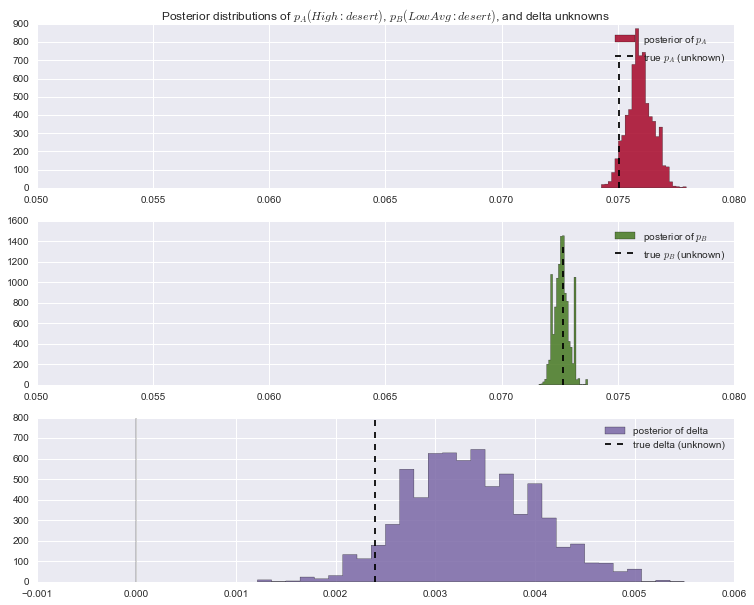

In [11]:
def plot_AB(p_A_samples, true_p_A, p_B_samples, true_p_B, delta_samples):
    figsize(12.5, 10)
    ax = plt.subplot(311)
    plt.xlim(0.05, .08)
    plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
             label="posterior of $p_A$", color="#A60628", normed=True)
    plt.vlines(true_p_A, 0, 700, linestyle="--", label="true $p_A$ (unknown)")
    plt.legend(loc="upper right")
    plt.title("Posterior distributions of $p_A(High:desert)$, $p_B(LowAvg:desert)$, and delta unknowns")
    
    ax = plt.subplot(312)
    plt.xlim(0.05, .08)
    plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
             label="posterior of $p_B$", color="#467821", normed=True)
    plt.vlines(true_p_B, 0, 1400, linestyle="--", label="true $p_B$ (unknown)")
    plt.legend(loc="upper right")
    
    ax = plt.subplot(313)
    plt.xlim(-0.001, .006)
    plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
             label="posterior of delta", color="#7A68A6", normed=True)
    plt.vlines(true_p_A - true_p_B, 0, 800, linestyle="--",label="true delta (unknown)")
    plt.vlines(0, 0, 800, color="black", alpha=0.2)
    plt.legend(loc="upper right");

plot_AB(p_A_samples, true_p_A, p_B_samples, true_p_B, delta_samples)

Because there is have less high food desert counties, our posterior distribution of pA (prob of high food desert county resident having DM) is fatter, implying we are less certain about the true value of pA than we are of pB (prob of low food desert county resident having DM).
However, we can see that the majority of the posterior distribution of delta is above delta=0, implying that high food desert county residents are more likely to be diabetic than residents living in a low to average food desert county. The probability that this inference is incorrect is computed below:

In [12]:
# Count the number of samples less than 0, i.e. the area under the curve
# before 0, represents the probability that A residents are 
# less likely to be diabetic than B residents.
print "Probability high food desert counties have LESS diabetic residents than low food desert counties: %.3f" % \
(delta_samples < 0).mean()

print "Probability high food desert counties have More diabetic residents than low food desert counties: %.3f" % \
(delta_samples > 0).mean()

Probability high food desert counties have LESS diabetic residents than low food desert counties: 0.000
Probability high food desert counties have More diabetic residents than low food desert counties: 1.000


Therefore we can state the probability of a California resident being diabetic is significantly less if they live in a county that has a low to average prevelance of food deserts. Similarly, we can also state those living in CA counties with a high prevelance of food deserts are significantly more likely to be diabetic.